# Loading libraries and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [91]:
data = pd.read_csv('train.csv').sample(frac=0.1, replace=True, random_state=2)
data = data.reset_index(drop=True)


# Data characteristics

In [92]:
print("Shape: ", data.shape)
data.head()

Shape:  (30000, 25)


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,100879,0,0,1,T,Y,Green,Circle,Lion,Russia,...,e1b66f5f2,1,Novice,Boiling Hot,c,B,ri,1,3,0
1,203245,0,0,0,F,Y,Blue,Trapezoid,Cat,Finland,...,506b8e5dd,1,Expert,Freezing,j,I,ZS,1,3,0
2,95816,0,0,1,F,Y,Blue,Square,Snake,India,...,602bcc56f,1,Novice,Freezing,g,F,tM,1,4,1
3,84434,0,0,0,T,N,Green,Triangle,Dog,China,...,97616a1ac,1,Grandmaster,Cold,l,Z,Uu,1,2,1
4,33867,0,0,0,F,Y,Red,Trapezoid,Snake,Russia,...,34058a17c,3,Master,Hot,a,Q,CM,4,1,0


In [93]:
data.nunique()

id        28536
bin_0         2
bin_1         2
bin_2         2
bin_3         2
bin_4         2
nom_0         3
nom_1         6
nom_2         6
nom_3         6
nom_4         4
nom_5       222
nom_6       519
nom_7      1199
nom_8      2143
nom_9      9629
ord_0         3
ord_1         5
ord_2         6
ord_3        15
ord_4        26
ord_5       192
day           7
month        12
target        2
dtype: int64

In [94]:
data.dtypes

id         int64
bin_0      int64
bin_1      int64
bin_2      int64
bin_3     object
bin_4     object
nom_0     object
nom_1     object
nom_2     object
nom_3     object
nom_4     object
nom_5     object
nom_6     object
nom_7     object
nom_8     object
nom_9     object
ord_0      int64
ord_1     object
ord_2     object
ord_3     object
ord_4     object
ord_5     object
day        int64
month      int64
target     int64
dtype: object

# Data preprocessing and cleaning

In [95]:
#columns that we can use directly
ready_columns = ['bin_0', 'bin_1', 'bin_2']

#categorical columns with string data
str_categorical_columns = ['bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'ord_1', 'ord_2', 'ord_3', 'ord_4']

#categorical columns with integer data
int_categorical_columns = ['ord_0', 'day', 'month']

#columns wiht integer alues
real_columns = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

#column ord_5 is processed alone.

YY = data['target']

Creating a new dataframe for ML

In [100]:
#function to process the data

def make_good_data_frame(in_data, n_pca = 0):
    #ready dataframe RD
    RD = in_data[ready_columns].copy()

    #String categorical dataframe SCD
    SCD = pd.get_dummies(in_data[str_categorical_columns], drop_first=True) 

    #Integer categorical dataframe ICD
    ICD = pd.get_dummies(in_data[int_categorical_columns[0]], drop_first=True)
    for i in range(1, len(int_categorical_columns)):
        temp_df = pd.get_dummies(in_data[int_categorical_columns[i]], drop_first=True)
        ICD = pd.merge(ICD, temp_df, left_index=True, right_index=True)
        
    #real columns
    realD = pd.DataFrame()
    for c in real_columns:
        realD[c] = in_data[c].apply(lambda x : int(x, 16))
    #realD = (realD - realD.mean())/realD.std()
    realD = (realD - realD.min())/(realD.max() - realD.min())
    
    #ord_5
    ord_5_D = pd.DataFrame()
    ord_5_D['ord_5'] = in_data['ord_5'].apply(lambda x : ord(x[0]) + ord(x[1]))
    #ord_5_D = (ord_5_D - ord_5_D.mean())/ord_5_D.std()
    ord_5_D = (ord_5_D - ord_5_D.min())/(ord_5_D.max() - ord_5_D.min())

    result = pd.merge(RD, SCD, left_index=True, right_index=True)
    result = pd.merge(result, ICD, left_index=True, right_index=True)
    result = pd.merge(result, realD, left_index=True, right_index=True)
    result = pd.merge(result, ord_5_D, left_index=True, right_index=True)
    
    
    #PCA
    if n_pca == 0:
        return result
    
    pca = PCA(n_components=n_pca)
    principalComponents = pca.fit_transform(result)
    result = pd.DataFrame(principalComponents)
    
    return result

XX = make_good_data_frame(data, 5)
XX.head()

,0,1,2,3,4
0,-0.656893,-0.607426,-0.623346,0.451209,0.632137
1,0.252320,0.167531,0.678132,-0.718085,-0.749068
2,-0.669434,0.137141,-0.696778,-0.767759,-0.049604
3,0.735309,-0.607054,0.680216,-0.103474,-0.082478
4,0.267044,0.839398,-0.131006,0.252828,-0.734837


# Clusterings

In [101]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2, random_state=0).fit(XX)

In [102]:
kmeans.labels_

array([1, 0, 1, ..., 1, 0, 0], dtype=int32)

In [103]:
goods=0
for x,y in zip(kmeans.labels_, data['target']):
    if x == y:
        goods += 1
print(goods/len(data))

0.4765


In [66]:
kmeans.cluster_centers_

array([[ 0.58360847,  0.17933948, -0.03601322],
       [-0.36896248, -0.11338002,  0.02276788]])

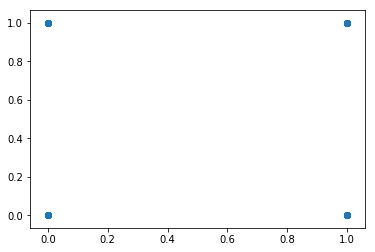

In [81]:
plt.scatter(kmeans.labels_, data['target'])